In [1]:
import os
import pandas as pd
from tqdm import tqdm
import torch
from rdkit.Chem import CanonSmiles

from mhfp.encoder import MHFPEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from utils import _process_euos_data

# Load model and training data

In [2]:
fingerprint_name = "mhfp6"
model_name = "rf"
model = torch.load(f"../models/combined/{fingerprint_name}_{model_name}.pkl")

In [3]:
training_df = pd.read_csv("../data/splits/combined/mhfp6_smote_train.csv")
training_df.head(2)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2039,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047,label
0,14433155,9273576,52428387,55778289,29319974,24922436,192953238,62403804,49040351,48020618,...,11055388,21431025,1416250,32703087,41181622,4925637,3638752,3279595,4090642,gram-positive
1,19469312,71257929,14316170,121213539,115681127,75668513,127870555,119200764,327151351,164407546,...,15596084,3736543,1416250,32970732,158260114,15628711,48984996,10981154,126156214,inactive


# Load testing data - EU-OS Library

In [4]:
if not os.path.exists("../data/benchmark/euos_data_cleaned.tsv"):
    _process_euos_data()
euos_df = pd.read_csv("../data/benchmark/euos_data_cleaned.tsv", sep="\t")

In [5]:
euos_df.shape

(101024, 10)

# Generate fingerprints

In [6]:
mhfp_encoder = MHFPEncoder(n_permutations=2048, seed=42)  # MHFP6 fingerprint

In [7]:
mhfp6_fingerprints = []

for smiles in tqdm(euos_df["smiles"].values):
    # Generate the mol object
    can_smiles = CanonSmiles(smiles)

    if not can_smiles:
        mhfp6_fingerprints.append(None)
        continue

    mhfp6_fingerprints.append(mhfp_encoder.encode(can_smiles, radius=3))

euos_df[fingerprint_name] = mhfp6_fingerprints

100%|██████████| 101024/101024 [10:33<00:00, 159.54it/s]


# Performing predictions

In [8]:
predictions = model.predict(euos_df[fingerprint_name].tolist())
prediction_proba = model.predict_proba(euos_df[fingerprint_name].tolist())
label_classes = model.classes_.tolist()

/Users/yojana/anaconda3/envs/amr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yojana/anaconda3/envs/amr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [9]:
euos_df["prediction"] = predictions

In [10]:
probs = []

for idx, probability in enumerate(prediction_proba):
    predicted_class = predictions[idx]
    probs.append(probability[label_classes.index(predicted_class)])

euos_df["probability"] = probs

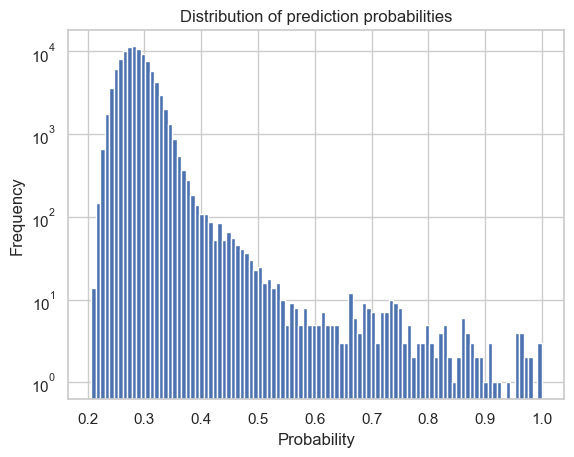

In [11]:
sns.set(style="whitegrid")
euos_df["probability"].plot(kind="hist", bins=100)
plt.yscale("log")
plt.xlabel("Probability")
plt.title("Distribution of prediction probabilities")
plt.show()

# Saving the predictions

In [12]:
euos_df.sort_values("probability", ascending=False, inplace=True)

In [13]:
euos_df.shape

(101024, 13)

In [14]:
os.makedirs("../data/predictions", exist_ok=True)
euos_df.to_csv("../data/predictions/combined_euos_predictions.csv", index=False)